In [43]:
from pathlib import Path

import torch
from torch.nn import Module, Linear, ReLU
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adagrad

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [44]:
PATH_MODELS = Path('models')
if not PATH_MODELS.exists():
    PATH_MODELS.mkdir()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [45]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## Згенерував точки

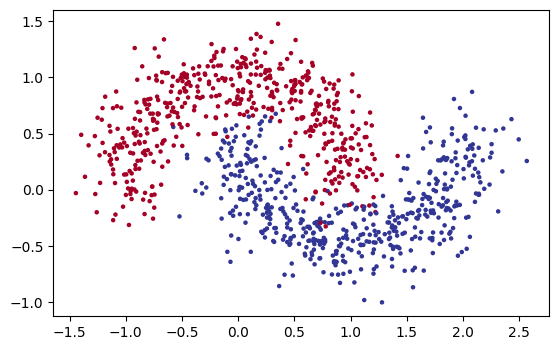

[[-0.11166654  0.52022374]
 [ 1.14264982 -0.34257734]
 [ 0.79555796 -0.01144231]
 ...
 [ 1.72760808 -0.42882943]
 [-1.01448644  0.13522904]
 [ 0.77438101  0.63428493]]


In [46]:
n_samples = 1000
noise = 0.20

X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
fig, ax = plt.subplots()
ax.scatter(x=X[:, 0], y=X[:, 1], c=y, s=5, cmap='RdYlBu')
ax.set_aspect('equal', 'box')
plt.show()
print(X)

## Перевів у тензори

In [47]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)
print(X.shape, y.shape)

torch.Size([1000, 2]) torch.Size([1000])


## Роблю поділ на train/test/validation

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(len(X_train), len(X_valid), len(y_train), len(y_valid))

640 160 640 160


In [50]:
print('Train:', len(X_train), len(y_train))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))

Train: 640 640
Valid: 160 160
Test: 200 200


## Створює модель нейронної мережі, функцію втрат та оптимізатор

In [51]:
class MoonModel(Module):
    __input_neurons = 2
    __output_neurons = 1

    def __init__(self, layer2_neurons, layer3_neurons):
        super().__init__()
        self.layer2 = Linear(self.__input_neurons, layer2_neurons) 
        self.layer3 = Linear(layer2_neurons, layer3_neurons)
        self.layer_output = Linear(layer3_neurons, self.__output_neurons)
        self.activate = ReLU()
        
    def forward(self, x):
        result = self.activate(self.layer2(x))
        result = self.activate(self.layer3(result))
        result = self.layer_output(result)
        return result
        

In [52]:
model = MoonModel(layer2_neurons=10, layer3_neurons=10).to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = Adagrad(params=model.parameters(), lr=0.05)

In [53]:
def accuracy(y_pred, y_true):
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    right_count = torch.eq(y_true, y_pred).sum().item()
    return right_count / len(y_true) * 100.0

## Навчаю модель

In [54]:
epochs = 1000

In [55]:
for epoch in range(epochs):
    #Перевів модель у трейн
    model.train()
    
    #запуск forward(перевизначения в __call__ Moduls)
    y_train_logits = model(X_train).squeeze()
    y_train_pred = torch.round(torch.sigmoid(y_train_logits))
    
    #рахую лог функцію втрат
    train_loss = loss_fn(y_train_logits, y_train)
    train_accuracy = accuracy(y_train_pred, y_train)
    
    #обнуляю старі градієнти
    optimizer.zero_grad()
    
    #запускаю backpropagation
    train_loss.backward()
    
    #застосовую оптимізатор
    optimizer.step()
    
    #перевірка теста під час навчання
    #переводжу в режим оцінки(валідую), дропаут, батчі викл
    model.eval()
    #викл градієнти
    with torch.inference_mode():
        #forward на валід
        y_valid_logits = model(X_valid).squeeze()
        y_valid_pred = torch.round(torch.sigmoid(y_valid_logits))
        #рахую лог функцію втрат
        valid_loss = loss_fn(y_valid_logits, y_valid)
        valid_accuracy = accuracy(y_valid_pred, y_valid)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}")
        print(f"Train: BCE:{train_loss:.5f} | {train_accuracy:.2f}%")
        print(f"Valid: BCE:{valid_loss:.5f} | {valid_accuracy:.2f}%")

Epoch: 0
Train: BCE:0.69493 | 39.53%
Valid: BCE:0.65899 | 75.00%


Epoch: 100
Train: BCE:0.14960 | 95.16%
Valid: BCE:0.13024 | 95.62%
Epoch: 200
Train: BCE:0.09798 | 96.25%
Valid: BCE:0.07781 | 96.88%
Epoch: 300
Train: BCE:0.08247 | 96.88%
Valid: BCE:0.06347 | 97.50%
Epoch: 400
Train: BCE:0.07447 | 97.03%
Valid: BCE:0.05421 | 97.50%
Epoch: 500
Train: BCE:0.07053 | 96.88%
Valid: BCE:0.04966 | 98.75%
Epoch: 600
Train: BCE:0.06842 | 97.03%
Valid: BCE:0.04800 | 98.12%
Epoch: 700
Train: BCE:0.06743 | 97.34%
Valid: BCE:0.04665 | 98.12%
Epoch: 800
Train: BCE:0.06677 | 97.50%
Valid: BCE:0.04572 | 98.12%
Epoch: 900
Train: BCE:0.06639 | 97.19%
Valid: BCE:0.04452 | 98.12%


# Візуалізація результатів

In [56]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

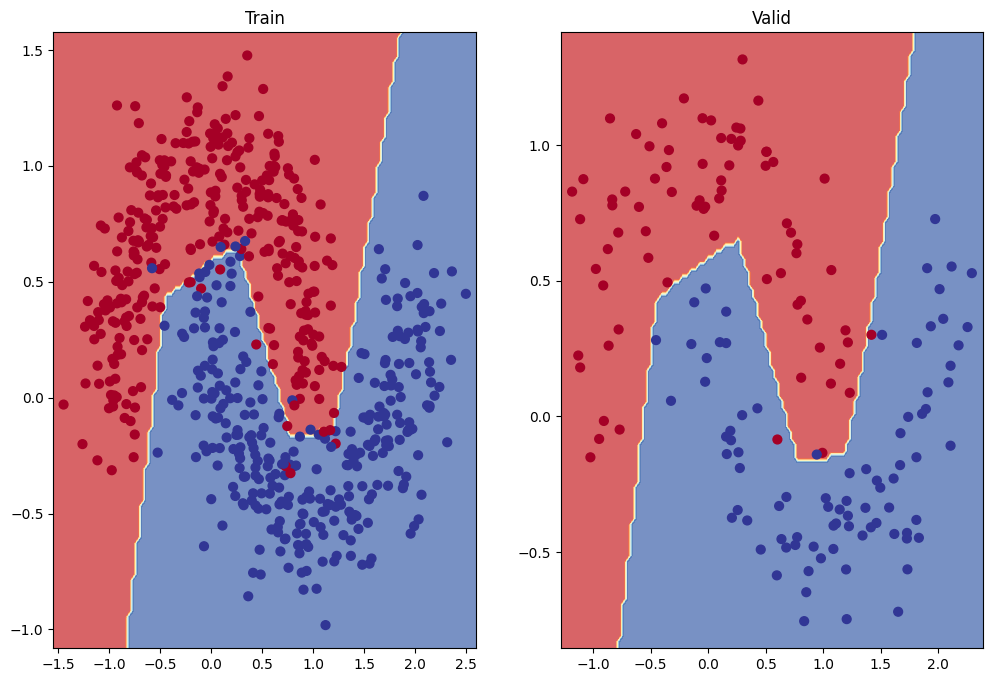

In [57]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Valid")
plot_decision_boundary(model, X_valid, y_valid)

## Зберігаю параметри

In [58]:
PATH_MOON_MODEL_PARAMS = PATH_MODELS / "moon_model_params.pth"
print(f"Saving model to: {PATH_MOON_MODEL_PARAMS}")
torch.save(obj=model.state_dict(), f=PATH_MOON_MODEL_PARAMS) 

Saving model to: models\moon_model_params.pth


## Завантажую модель через клас та параметри

In [59]:
test_model = MoonModel(layer2_neurons=10, layer3_neurons=10)
test_model.load_state_dict(torch.load(PATH_MOON_MODEL_PARAMS))
test_model = test_model.to(device)

## Роблю предікт тесту

In [60]:
test_model.eval()
with torch.inference_mode():
    y_test_logits = test_model(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    test_loss = loss_fn(y_test_logits, y_test)
    test_accuracy = accuracy(y_test_pred, y_test)
    print(f"Test: BCE:{test_loss:.5f} | {test_accuracy:.2f}%")

    


Test: BCE:0.04203 | 99.00%


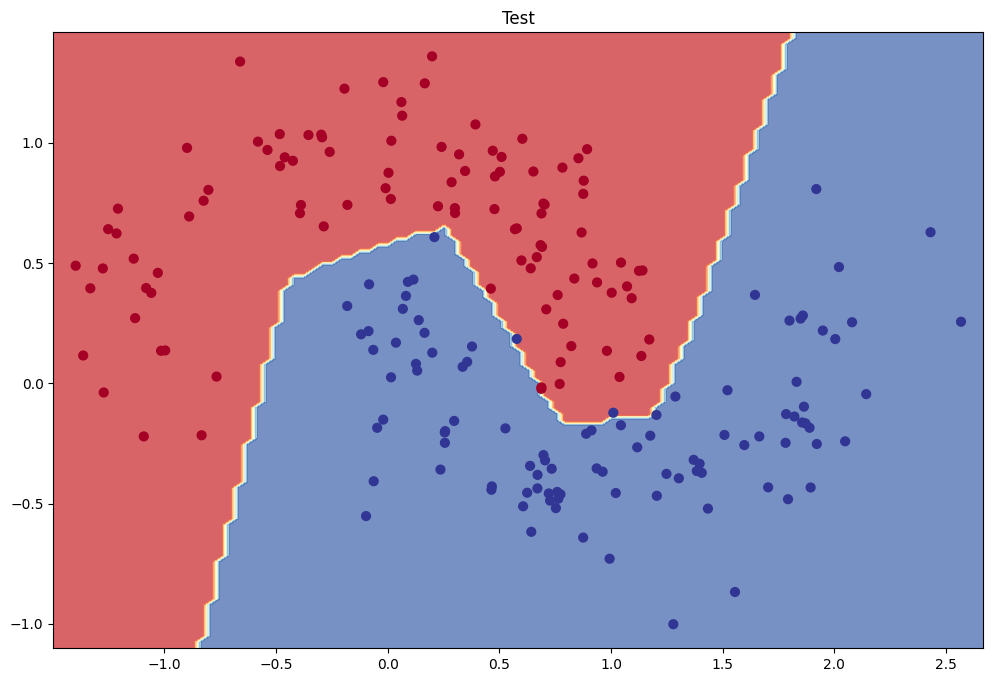

In [61]:
plt.figure(figsize=(12, 8))
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## Зберігаю всю модель, а не тільки параметри

In [62]:
PATH_MOON_MODEL = PATH_MODELS / "moon_model.pth"
print(f"Saving model to: {PATH_MOON_MODEL}")
torch.save(obj=model, f=PATH_MOON_MODEL)


Saving model to: models\moon_model.pth


## Завантажую

In [63]:
loaded_model = torch.load(PATH_MOON_MODEL ,map_location=device, weights_only=False)
loaded_model.eval()
with torch.inference_mode():
    y_test_logits = loaded_model(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    test_loss = loss_fn(y_test_logits, y_test)
    test_accuracy = accuracy(y_test_pred, y_test)
    print(f"Test: BCE:{test_loss:.5f} | {test_accuracy:.2f}%")

Test: BCE:0.04203 | 99.00%
